In [1]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

from sklearn.metrics import pairwise_distances
import lxml.etree
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from IPython.display import display

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

## Loading and preprocessing

In [2]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
266,van_ses_vaerwen,Van ses vaerwen ende twaelf outheyden,NaN,1410.0,cdrom-mnl,1400-1420,Epiek,Didactiek,NaN
63,florigout_fragm_l,Florigout,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Ridder,NaN
111,loyhier_en_malaert_fragm_a,Loyhier en Malaert,NaN,1375.0,cdrom-mnl,1350-1400,Epiek,Karel,NaN
86,historie_van_gaver_capeel,Historie van Gaver Capeel,NaN,1510.0,cdrom-mnl,1500-1520,Epiek,Ridder,NaN
168,renout_van_montalbaen_fragm_be,Renout van Montalbaen,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Karel,NaN
211,spiegel_der_sonden,Spiegel der sonden,NaN,1450.0,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
210,spiegel_der_jongers,Spiegel der jongers,Lambertus Goetman,1515.0,cdrom-mnl,1510-1520,Epiek,Didactiek,NaN
123,madelgijs_fragm_p,Madelgijs,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
166,reinaerts_historie,Reinaerts historie,NaN,1470.0,cdrom-mnl,1460-1480,Epiek,Dier,NaN
239,suverlijc_boecxken,Suverlijc boecxken,NaN,1508.0,cdrom-mnl,1508-1508,Lyriek,NaN,NaN


In [3]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [4]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        try:
            tree = lxml.etree.parse(f'../data/xml/{id_}.xml')
        except OSError:
            print(f'- Could not load {id_}')
            continue
        
        # don't remove interpolations?
        #for interpolation in tree.xpath("//interpolation"):
        #    interpolation.getparent().remove(interpolation)
        
        for line_node in tree.iterfind('//l'):
            try:
                intertext_id = line_node.attrib['intertext']
            except KeyError:
                intertext_id = None
            
            tokens_ = line_node.attrib['tokens'].split()
            lemmas_ = []
            
            lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
            pos_tags = [p.text for p in line_node.iterfind('.//pos')]
            
            for lemma, pos in zip(lemma_tags, pos_tags):
                for l, p in zip(lemma.split('+'), pos.split('+')):
                        if p == 'n(prop)':
                            lemmas_.append('n(prop)')
                        else:
                            lemmas_.append(l)
        
            work_tokens.append(tokens_)
            work_lemmas.append(lemmas_)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 205/205 [00:37<00:00,  5.54it/s]


In [5]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext
340265,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2
340301,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47
340313,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5
340352,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8
340380,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10
340382,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11
340455,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15
340479,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16
340545,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17
340559,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19


In [6]:
vec = TfidfVectorizer(max_features=10000, min_df=2, token_pattern=r"(?u)\b\w+\b")
X = vec.fit_transform(df['lemmas'])
X.shape

(924489, 10000)

In [7]:
rhyme_words = []
for lemmas in df['lemmas']:
    rhymes = []
    for verse in lemmas.split(' / '):
        rhymes.append(verse.strip().split()[-1])
    rhyme_words.append(' '.join(rhymes))
df['rhyme'] = rhyme_words

df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext,rhyme
340265,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2,hof lof
340301,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47,verenen menen
340313,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5,groot genoot
340352,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8,achter lachter
340380,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10,land onbekend
340382,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11,gereden kleden
340455,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15,weten list
340479,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16,land onbekend
340545,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17,wel el
340559,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19,zin in


## Nearest neighbors

In [8]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.25):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [9]:
nearest_df = nearest_verses('Moriaen', 'Karel ende Elegast',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
163,Nu es leden die derde dach / Dat ic voer om min bejach,Dies is leden die derde dach / Dat ic voer om mijn beiach,nu zijn lijden de derde dag / dat ik varen om mijn bejag,die zijn lijden de derde dag / dat ik varen om mijn bejag,Moriaen,Karel ende Elegast,mor-ele-44,mor-ele-44,0.032440
2909,Ende segt mi ende maect mi vroet / Wat noetsaken dat u doet,In dien dat ghi mi maket vroet / Wat nootsaken dat v doet,en zeggen ik en maken ik vroed / wat noodzaak dat gij doen,in die dat gij ik maken vroed / wat noodzaak dat uw doen,Moriaen,Karel ende Elegast,mor-ele-31,mor-ele-31,0.113171
193,Want ic come u te genaden / Van allen minen mesdaden,Ic come v heden te ghenaden / Van allen minen misdaden,want ik komen gij te genade / van al mijn misdaad,ik komen gij heden te genade / van al mijn misdaad,Moriaen,Karel ende Elegast,mor-ele-72,mor-ele-72,0.119932
1288,Men doet mi lachter onverdient / Quame enech Gods vrient,Dadi mi lachter onuerdient / Ghi hadt verloren menigen vrient,men doen ik lachter onverdiend / komen enig god vriend,doen ik lachter onverdiend / gij hebben verliezen menig vriend,Moriaen,Karel ende Elegast,None,None,0.180558
1839,Die grote ondaet ende die mort / Hi sprac te sinen lieden vort,Dat ghi segt ende brenct voort / Die ondaet ende die moort,de groot ondaad en de moord / hij spreken te zijn lieden voort,dat gij zeggen en brengen voort / de ondaad en de moord,Moriaen,Karel ende Elegast,mor-ele-70,mor-ele-70,0.184409
447,Dan mi een ridder dwingen soude / Van dies ic doen nine woude,Dat mi een man dwinghen soude / Van dinghen die ic niet en woude,dan ik een ridder dwingen zullen / van die ik doen ne niet willen,dat ik een man dwingen zullen / van ding die ik niet ne willen,Moriaen,Karel ende Elegast,mor-ele-22,mor-ele-22,0.195141
893,U ne gesciets niet te wors / Her Walewein sat doe op sijn ors,Al souts mi sijn te wors / Nv sit weder op v ors,gij ne geschieden niet te waars / heer n(prop) zitten toen op zijn hors,al zullen ik zijn te waars / nu zitten weer op uw hors,Moriaen,Karel ende Elegast,mor-ele-78,mor-ele-78,0.204883
877,Maer wistic uwer beider name / Ende u wille ware ende bequame,Ick sel v segghen minen name / Ist v wille ende bequame,maar ik weten uw beide naam / en uw wil zijn en bekwaam,ik zullen gij zeggen mijn naam / zijn het uw wil en bekwaam,Moriaen,Karel ende Elegast,mor-ele-38,mor-ele-38,0.205618
2949,Si hadden daer soe grote macht / Ende vingen Arture met harre cracht,Eggeric was van groter macht / Ende alle die hadden cracht,zij hebben daar zo groot macht / en vangen n(prop) met haar kracht,n(prop) zijn van groot macht / en al die hebben kracht,Moriaen,Karel ende Elegast,None,None,0.229387
3763,Doe pensdi in sinen moet / Op dattie trappen waren so goet,Pensde hi in sinen moet / Dat ick leue waer toe ist goet,toen hij peinzen in zijn moed / op dat de n(prop) zijn zo goed,peinzen hij in zijn moed / dat ik leven zijn toe zijn het goed,Moriaen,Karel ende Elegast,None,None,0.233526


In [10]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks,Unnamed: 8
0,mor-ele-1,Moriaen,Dat magic v nv tellen,Karel ende Elegast,Mach ic v tellen,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
1,mor-ele-2,Moriaen,hilt hof Om te merre sinen lof.,Karel ende Elegast,houden hof Omme te meerne sinen lof:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
2,mor-ele-3,Moriaen,Hastelike ende nine spard.,Karel ende Elegast,Haestelic ende niet en spaert:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
3,mor-ele-4,Moriaen,Nv nes niweren in ertrike.,Karel ende Elegast,En es man in aertrijcke:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
4,mor-ele-5,Moriaen,sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.,Karel ende Elegast,Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:,3,"Heeroma 1973a, Moriaen (I)",NaN,NaN
...,...,...,...,...,...,...,...,...,...
224,mor-ele-40,Lantsloot van der Haghedochte,Ende droegen des ouer een:,Moriaen,Ende drogen des daer ouer een.,1,NaN,Nestedness!,NaN
225,mor-ele-61,Lantsloot van der Haghedochte,Dien hi harde lange voer Ende vernam van niemene boer:,Moriaen,Daer men met scepen ouer voer Ende daer verlosic al dat boer.,2,NaN,NaN,NaN
226,lan-ele-74,Lantsloot van der Haghedochte,Ende sijn ors toe gemake gedaen:,Moriaen,Sijn ors was te gemake gedaen.,1,NaN,NaN,NaN
227,lan-ele-75,Lantsloot van der Haghedochte,Doe die dienst was gedaen:,Moriaen,Doe die dinst was gedaen.,1,NaN,NaN,NaN


## Precision-recall paradigm

In [11]:
def precision_recall(df, meta, vec, rhyme_weight=.25):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

In [12]:
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=0)

Use complement of the cosine distance as a pseudo-probability:

In [13]:
distances = 1 - np.array(distances)

max(f1)=0.3538 @ theta=0.5008


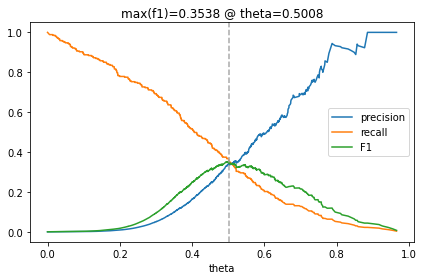

In [14]:
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

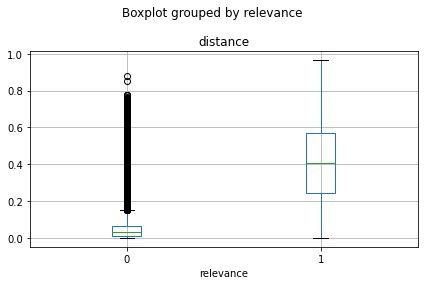

In [15]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

#### Calibrate parameters

Like rhyme weight:

In [16]:
scores = []

# also negative weight for demonstration purposes:
rhyme_weights = tuple(np.linspace(-.3, 2.0, 50))

from sklearn.metrics import roc_auc_score

for rhyme_weight in tqdm(rhyme_weights):
    relevances, distances = precision_recall(df, meta, vec, rhyme_weight=rhyme_weight)
    distances = 1 - np.array(distances)
    auc = roc_auc_score(relevances, distances)
    av_prec = average_precision_score(relevances, distances)
    scores.append((rhyme_weight, auc, av_prec))

100%|██████████| 50/50 [04:17<00:00,  5.15s/it]


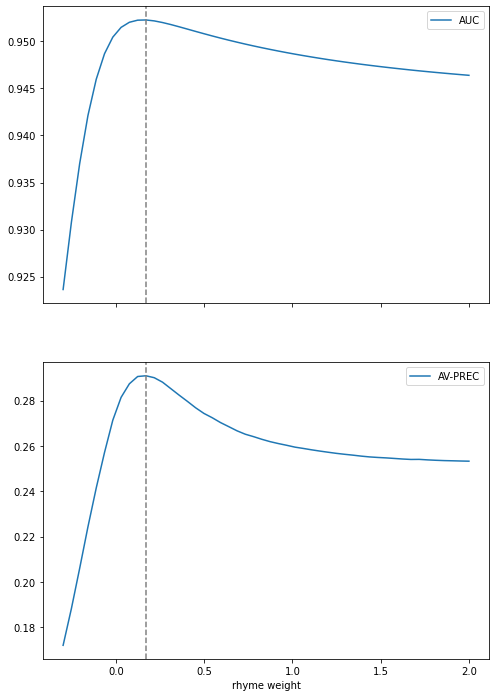

In [17]:
scores = pd.DataFrame(scores, columns=('rhyme weight', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
scores.plot('rhyme weight', 'AUC', ax=ax1)
ax1.axvline(scores.iloc[scores['AUC'].idxmax()]['rhyme weight'], ls='--', c='grey')
scores.plot('rhyme weight', 'AV-PREC', ax=ax2)
ax2.axvline(scores.iloc[scores['AV-PREC'].idxmax()]['rhyme weight'], ls='--', c='grey');

In [18]:
optim_rw = scores.iloc[scores['AUC'].idxmax()]['rhyme weight']
optim_rw

0.1693877551020408

Vocabulary size?

In [19]:
vec = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", min_df=2, max_features=None)
vec.fit(df['lemmas'])
print(len(vec.get_feature_names()))

40563


Vocabulary size for TF and TF-IDF:

In [20]:
scores = []

vocab_sizes = list(range(500, 20000, 500))
parametrizations = {
                    'TF-IDF': {'min_df':2},
                    'TF': {'use_idf':False, 'min_df':2},
                    }

for vocab_size in tqdm(vocab_sizes):
    for param_name, param in parametrizations.items():
        param['max_features'] = vocab_size
        vec = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", **param)
        vec.fit(df['lemmas'])
        relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
        distances = 1 - np.array(distances)
        auc = roc_auc_score(relevances, distances)
        av_prec = average_precision_score(relevances, distances)
        scores.append((param_name, vocab_size, auc, av_prec))
scores = pd.DataFrame(scores, columns=('param', 'vocab_size', 'AUC', 'AV-PREC'))

100%|██████████| 39/39 [17:06<00:00, 26.31s/it]


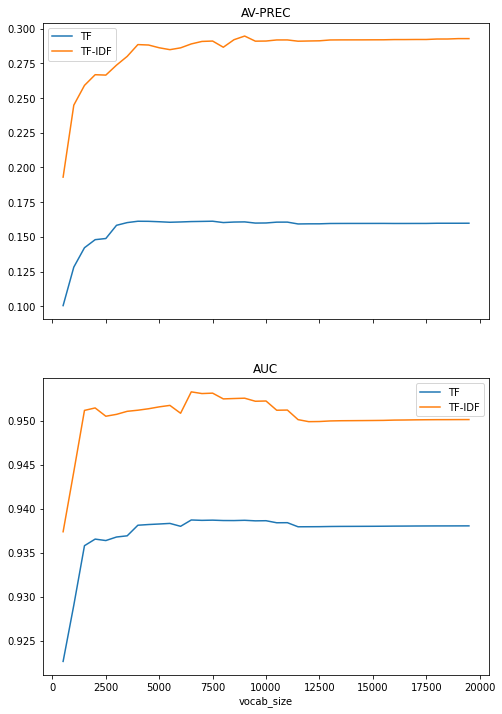

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))

for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AV-PREC', label=p, ax=ax1)
ax1.set_title('AV-PREC')
    
for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AUC', label=p, ax=ax2)
ax2.set_title('AUC');

In [22]:
scores['comb'] = scores['AUC'] * scores['AV-PREC']
optim_vs = scores.iloc[scores['AUC'].idxmax()]
display(optim_vs)
optim_vs = optim_vs['vocab_size']
#optim_vs

param         TF-IDF  
vocab_size    6500    
AUC           0.953289
AV-PREC       0.288892
comb          0.275398
Name: 24, dtype: object

## Final threshold

max(f1)=0.3587 @ theta=0.5624


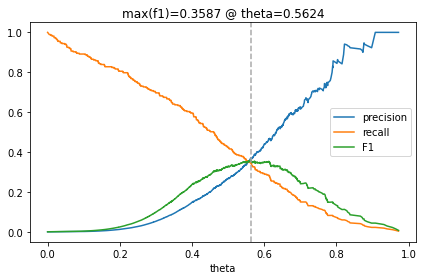

In [23]:
vec = TfidfVectorizer(max_features=40000, min_df=2,
                      token_pattern=r"(?u)\b\w+\b")
vec.fit(df['lemmas'])
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
distances = 1 - np.array(distances)
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

## Case studies

#### Well-known cases of intertextual borrowing

In [24]:
def distance_nn(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    def batch(iterable, n=1):
        l = iterable.shape[0]
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = []

    for ax in batch(AX, batch_size):
         all_distances.extend(pairwise_distances(ax, BX, metric='cosine').min(axis=1))
    
    return pd.Series(all_distances)

def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax)
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [25]:
rolling_size, threshold = 1000, 1 - max_f1_th
print(threshold)

0.43755583633231987


Heelu in de Vijfde Partie:

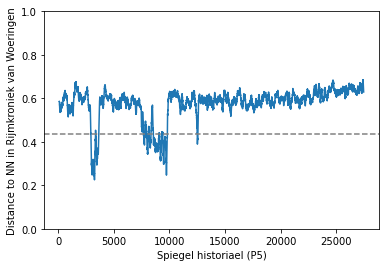

In [26]:
t1, t2 = 'Spiegel historiael (P5)', 'Rijmkroniek van Woeringen'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);

Maerlant in de Brabantse yeesten:

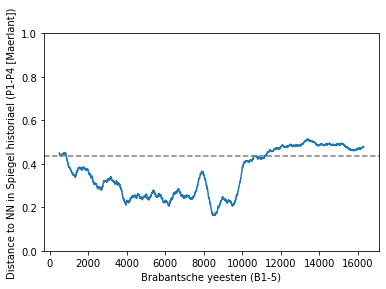

In [27]:
t1, t2 = 'Brabantsche yeesten (B1-5)', 'Spiegel historiael (P1-P4 [Maerlant])'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=500);

Walewein-passage in Moriaen:

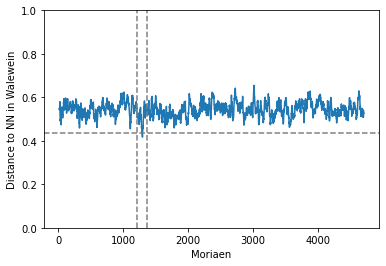

In [28]:
t1, t2 = 'Moriaen', 'Walewein'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=20)
ax.axvline(1215, c='grey', ls='--')
ax.axvline(1365, c='grey', ls='--');

#### Large-scale detection

In [29]:
#chiv_titles = meta_df[meta_df['subgenre'].isin(('Arthur', 'Ridder', 'Karel', 'Kruisvaart', 'Dier'))]['title'].unique()
chiv_titles = meta_df[meta_df['genre'] == 'Epiek']['title'].unique()
chiv_titles

array(['Alexanders geesten', 'Alexiuslegende', 'Anatomie van de mens',
       'Arturs doet', 'Aubri de Borgengoen', 'Barlaam en Josaphat',
       'Beatrijs', 'Bediedenisse van der missen',
       'Beerte metten breden voeten', 'Beginsel der oorlogen van Luyck',
       'Boec Exemplaer', 'Boec van den houte', 'Boec vander wraken',
       'Boeve van Hamtone', 'Borchgrave van Couchi',
       'Borchgravinne van Vergi (1)', 'Borchgravinne van Vergi (2)',
       'Boudewijn van Seborch', 'Brabantsche yeesten (B1-5)',
       'Brabantsche yeesten (B6)', 'Brabantsche yeesten (B7)',
       'Nevelingenlied', "Chanson d'Aspremont", 'Collectief lunarium I',
       'Collectief lunarium III', 'Commentaar op het Hooglied',
       'Collectief lunarium II', 'Cyromanchie van den pape van den Hamme',
       'Der leken spieghel', 'Der mannen ende vrouwen heimelijcheit',
       'Der minnen loep', 'Der naturen bloeme',
       'Der vrouwen heimelijcheit', 'Der ystorien bloeme',
       'Dietsche doctrinale', 'Di

In [30]:
results = []
for t1, t2 in tqdm(product(['Arturs doet'], chiv_titles)):
    if t1 == t2:
        continue
    results.append((t1, t2, distance_nn(t1, t2, batch_size=10000)))

161it [04:39,  1.74s/it]


In [31]:
results = pd.DataFrame(results, columns=('t1', 't2', 'nn'))
results

,t1,t2,nn
0,Arturs doet,Alexanders geesten,"0 0.602437 1 0.641553 2 0.590174 3 0.661309 4 0.660274 ... 13018 0.561574 13019 0.616901 13020 0.401516 13021 0.601564 13022 0.485653 Length: 13023, dtype: float64"
1,Arturs doet,Alexiuslegende,"0 0.849829 1 0.858629 2 0.922907 3 0.727783 4 0.744344 ... 13018 0.882321 13019 0.900610 13020 0.746825 13021 0.735185 13022 0.821958 Length: 13023, dtype: float64"
2,Arturs doet,Anatomie van de mens,"0 0.654095 1 0.751749 2 0.790968 3 0.884497 4 0.879541 ... 13018 0.585081 13019 0.715743 13020 0.807686 13021 0.665096 13022 0.730850 Length: 13023, dtype: float64"
3,Arturs doet,Aubri de Borgengoen,"0 0.781482 1 0.826974 2 0.797864 3 0.731678 4 0.746077 ... 13018 0.876706 13019 0.699313 13020 0.602510 13021 0.478650 13022 0.649453 Length: 13023, dtype: float64"
4,Arturs doet,Barlaam en Josaphat,"0 0.775853 1 0.684775 2 0.609517 3 0.699666 4 0.675600 ... 13018 0.854148 13019 0.821605 13020 0.786167 13021 0.786307 13022 0.806759 Length: 13023, dtype: float64"
...,...,...,...
155,Arturs doet,Walewein ende Keye,"0 0.787586 1 0.677824 2 0.657720 3 0.594157 4 0.598629 ... 13018 0.801093 13019 0.699103 13020 0.660710 13021 0.611642 13022 0.603842 Length: 13023, dtype: float64"
156,Arturs doet,Willem van Oringen,"0 0.834675 1 0.718953 2 0.713947 3 0.852151 4 0.822783 ... 13018 0.863190 13019 0.711329 13020 0.735184 13021 0.693270 13022 0.662375 Length: 13023, dtype: float64"
157,Arturs doet,Wisselau,"0 0.849178 1 0.758056 2 0.760541 3 0.855844 4 0.892687 ... 13018 0.789728 13019 0.766422 13020 0.786267 13021 0.664761 13022 0.628226 Length: 13023, dtype: float64"
158,Arturs doet,Wrake van Ragisel,"0 0.520856 1 0.691803 2 0.691570 3 0.605840 4 0.678365 ... 13018 0.622857 13019 0.702759 13020 0.671569 13021 0.583141 13022 0.675329 Length: 13023, dtype: float64"


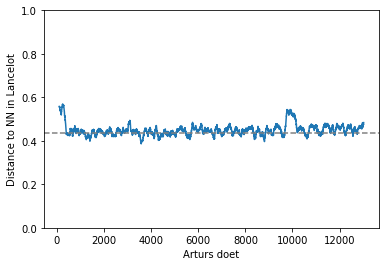

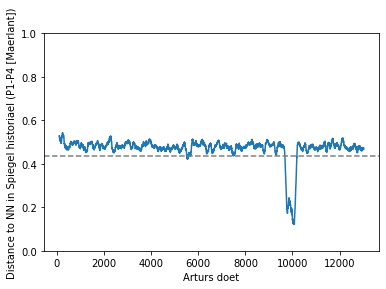

In [32]:
rolling_size = 100
for _, r in results.iterrows():
    if np.any(r['nn'].rolling(rolling_size).mean() < threshold):
        plot_min_distance_nn(r['t1'], r['t2'], r['nn'],
                         threshold=threshold, rolling_size=rolling_size);

### Single-text

In [33]:
d = results[results['t1'] == 'Arturs doet']
d

,t1,t2,nn
0,Arturs doet,Alexanders geesten,"0 0.602437 1 0.641553 2 0.590174 3 0.661309 4 0.660274 ... 13018 0.561574 13019 0.616901 13020 0.401516 13021 0.601564 13022 0.485653 Length: 13023, dtype: float64"
1,Arturs doet,Alexiuslegende,"0 0.849829 1 0.858629 2 0.922907 3 0.727783 4 0.744344 ... 13018 0.882321 13019 0.900610 13020 0.746825 13021 0.735185 13022 0.821958 Length: 13023, dtype: float64"
2,Arturs doet,Anatomie van de mens,"0 0.654095 1 0.751749 2 0.790968 3 0.884497 4 0.879541 ... 13018 0.585081 13019 0.715743 13020 0.807686 13021 0.665096 13022 0.730850 Length: 13023, dtype: float64"
3,Arturs doet,Aubri de Borgengoen,"0 0.781482 1 0.826974 2 0.797864 3 0.731678 4 0.746077 ... 13018 0.876706 13019 0.699313 13020 0.602510 13021 0.478650 13022 0.649453 Length: 13023, dtype: float64"
4,Arturs doet,Barlaam en Josaphat,"0 0.775853 1 0.684775 2 0.609517 3 0.699666 4 0.675600 ... 13018 0.854148 13019 0.821605 13020 0.786167 13021 0.786307 13022 0.806759 Length: 13023, dtype: float64"
...,...,...,...
155,Arturs doet,Walewein ende Keye,"0 0.787586 1 0.677824 2 0.657720 3 0.594157 4 0.598629 ... 13018 0.801093 13019 0.699103 13020 0.660710 13021 0.611642 13022 0.603842 Length: 13023, dtype: float64"
156,Arturs doet,Willem van Oringen,"0 0.834675 1 0.718953 2 0.713947 3 0.852151 4 0.822783 ... 13018 0.863190 13019 0.711329 13020 0.735184 13021 0.693270 13022 0.662375 Length: 13023, dtype: float64"
157,Arturs doet,Wisselau,"0 0.849178 1 0.758056 2 0.760541 3 0.855844 4 0.892687 ... 13018 0.789728 13019 0.766422 13020 0.786267 13021 0.664761 13022 0.628226 Length: 13023, dtype: float64"
158,Arturs doet,Wrake van Ragisel,"0 0.520856 1 0.691803 2 0.691570 3 0.605840 4 0.678365 ... 13018 0.622857 13019 0.702759 13020 0.671569 13021 0.583141 13022 0.675329 Length: 13023, dtype: float64"


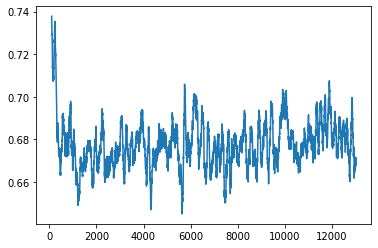

In [34]:
D = np.array([_ for _ in d['nn'].values])
D.shape
D = pd.DataFrame(D)

fig, ax = plt.subplots()
D.mean().rolling(100).mean().plot(ax=ax);